In [31]:
import os
import torch
import pickle 
from config import get_cfg_defaults
from data import SOS_ID, decode_sentence, encode_sentence, PAD_ID

from transformer import subsequent_mask
from torch.autograd import Variable

import matplotlib.pyplot as plt 
import seaborn as sns

In [13]:
DEVICE = torch.device('cpu')

In [14]:
exp_root = "/home/johann/sonstiges/transformer-pytorch/exps/2022-03-19_64_3_100"

In [15]:
cfg = get_cfg_defaults()
cfg.merge_from_file(os.path.join(exp_root, 'config.yaml'))
cfg.freeze()

In [16]:
with open(os.path.join(exp_root, 'dataset.file'), 'rb') as fp:
    dataset = pickle.load(fp)

In [17]:
model_checkpoint = os.path.join(exp_root, "en-de-model-iter-0000240000.pt")
model = torch.load(model_checkpoint)
model.eval()
model.to(DEVICE)

Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
  

In [18]:
test_sentence = "hi my name is johann and i am a scientific researcher from germany who loves hacking."

In [34]:
encoded = encode_sentence(cfg, dataset, test_sentence)


17

In [20]:
encoded_t = torch.tensor(encoded).unsqueeze(0).to(DEVICE)

In [21]:
encoded_mask = (encoded_t != 0).unsqueeze(-2).to(DEVICE)


In [22]:
encoded_t = model.encode(encoded_t, encoded_mask)

In [23]:
tgt = torch.ones(1,1).fill_(SOS_ID)
tgt = tgt.long()

with torch.no_grad():
    for i in range(99):
        out = model.decode(
            encoded_t, encoded_mask, 
            Variable(tgt), Variable(subsequent_mask(tgt.size(1)))
        )
        probs = model.generator(out[:, -1])
        _, nextword = torch.max(probs, dim=1)
        nextword = nextword.item()
        tgt = torch.cat([
            tgt, torch.ones(1,1).fill_(nextword).long()
        ], dim=1)
        

In [24]:
translation_ = tgt[0].detach().cpu().numpy().tolist()

In [25]:
translation = decode_sentence(dataset.tgt_idx2word, translation_)
print(translation)

mein name ist johann und ich bin ein wissenschaftlicher forscher aus deutschland , der <unk> liebt .


In [26]:
len(model.encoder.layers)

6

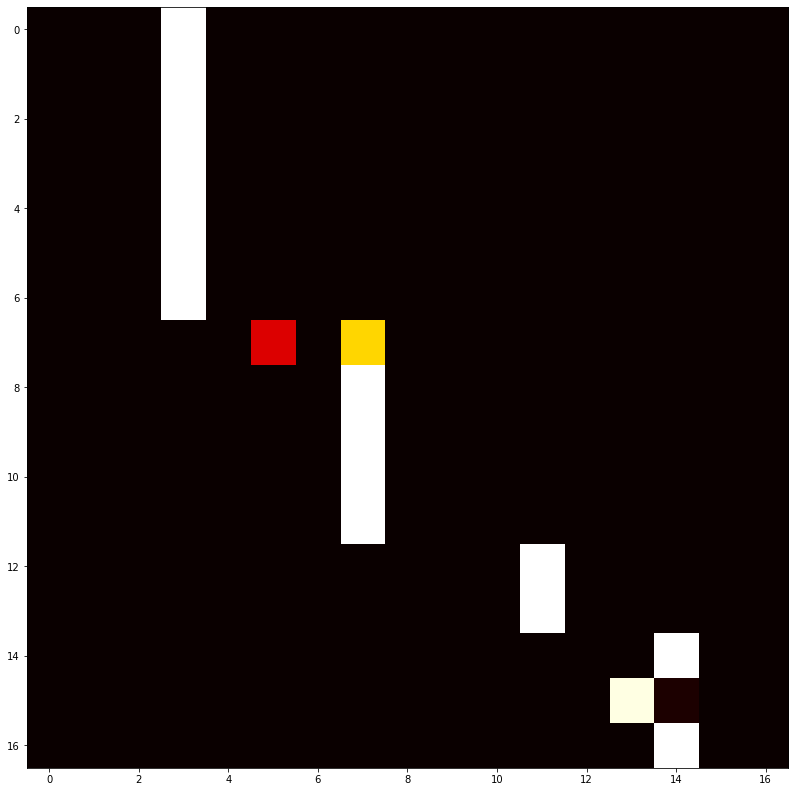

In [39]:
head = 3
layer = 3
sen_len = sum([1 for el in encoded if el != PAD_ID])
attn_map = model.encoder.layers[layer].self_attn.attn[0, head].data[:sen_len, :sen_len]
plt.figure(figsize=(14,14))
plt.imshow(attn_map, cmap="hot")

In [59]:
def draw(data, x, y, ax):
    sns.heatmap(data, 
                    xticklabels=x, 
                    square=True, 
                    yticklabels=y, 
                    vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)

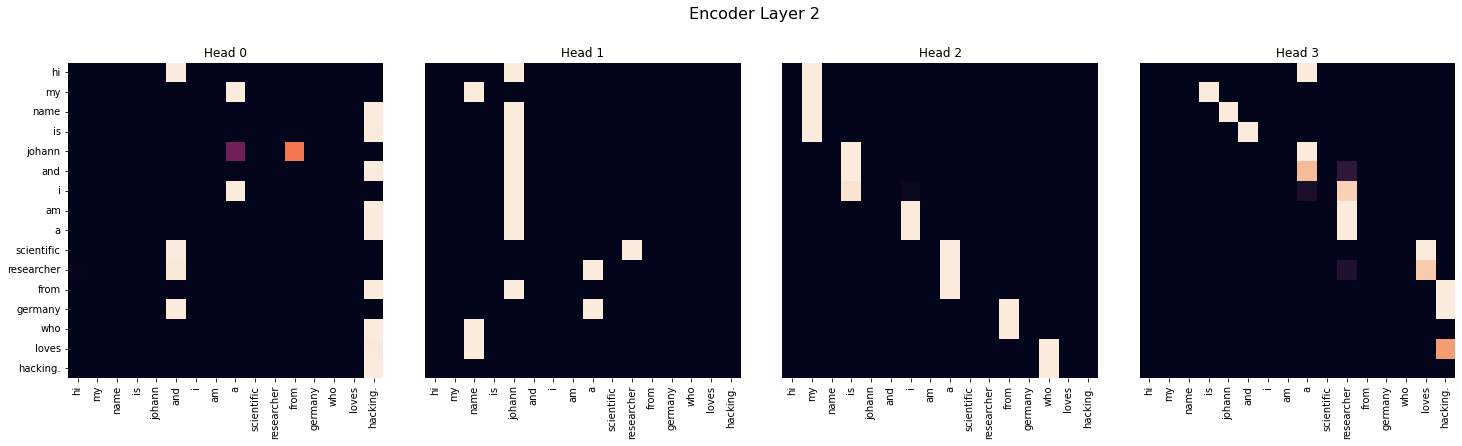

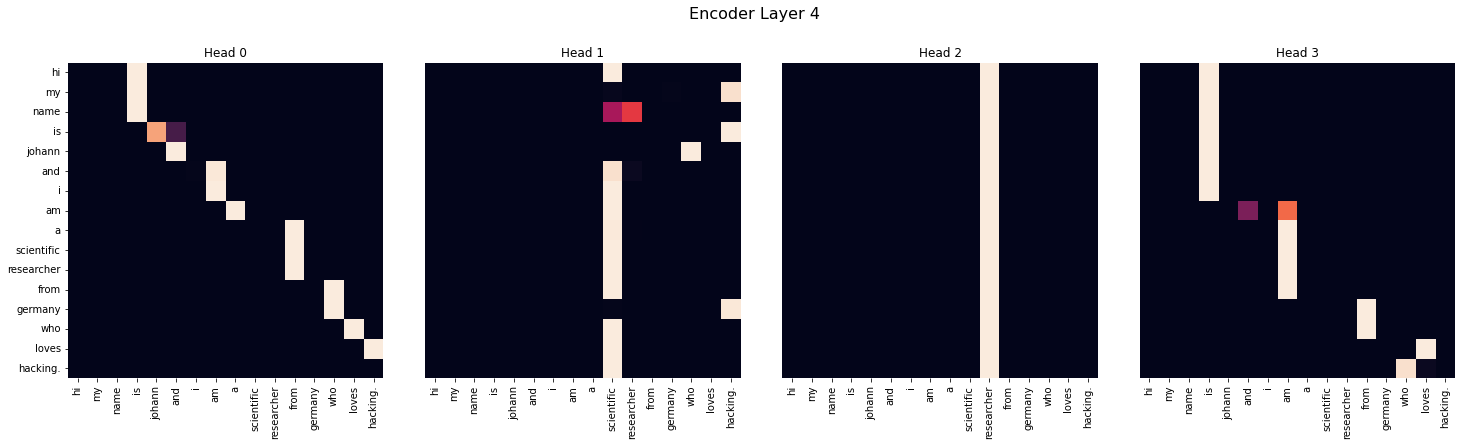

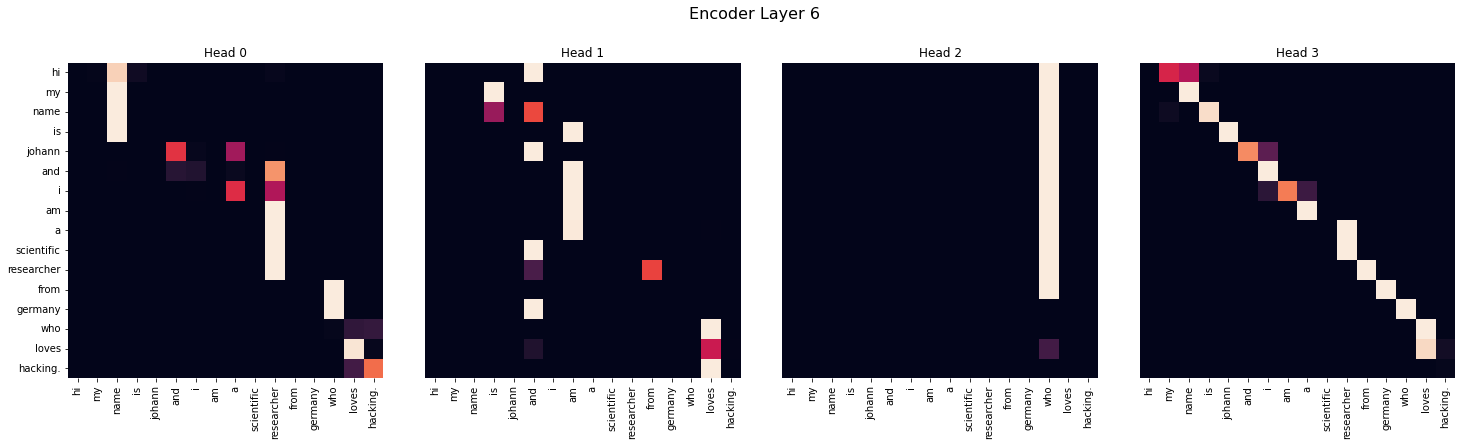

In [60]:
sent = test_sentence.split()

for layer in range(1, len(model.encoder.layers), 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 6))
    fig.suptitle(f"Encoder Layer {layer+1}", fontsize=16)
    fig.tight_layout()
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data[:len(sent), :len(sent)], 
            sent, sent if h ==0 else [], ax=axs[h])
        axs[h].set_title(f"Head {h}")
    plt.show()
    fig.savefig(f"encoder_attn_{layer+1}.jpg")

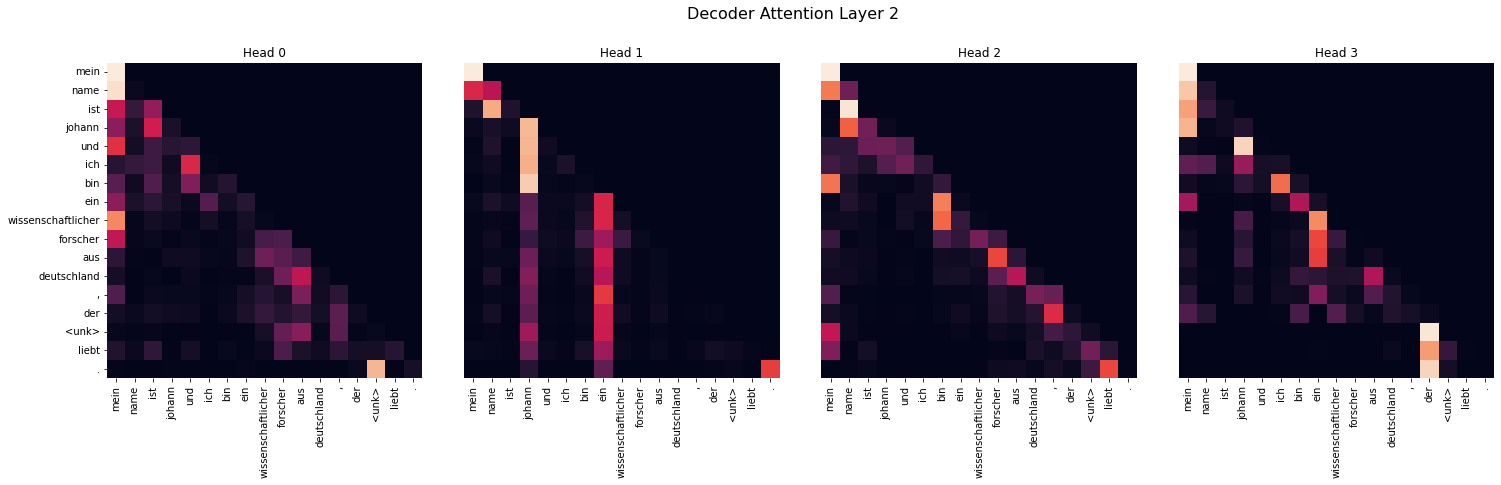

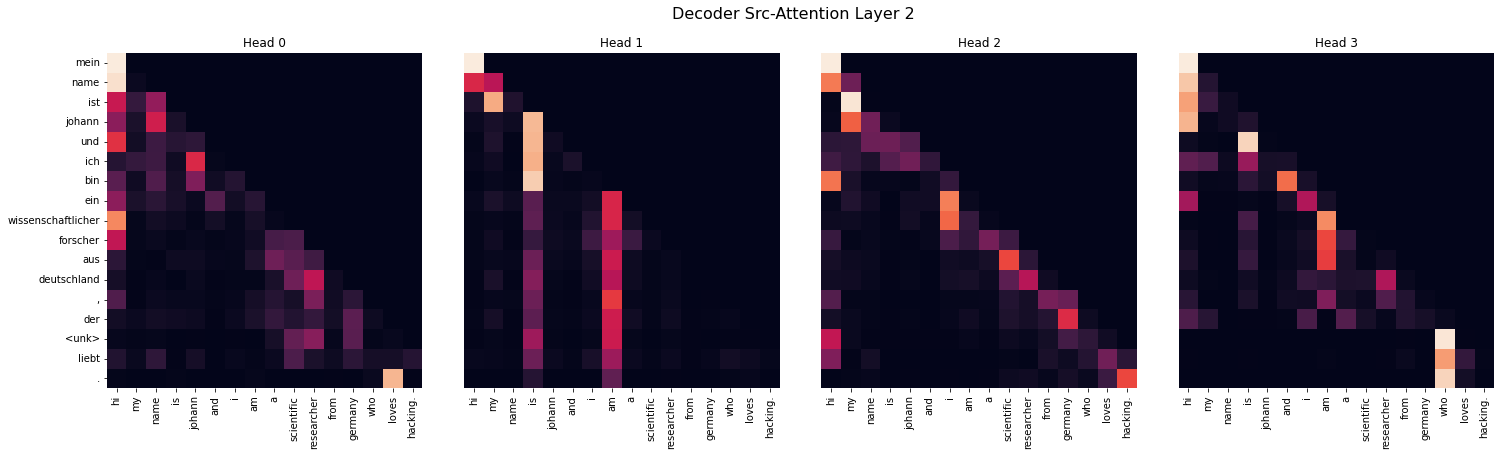

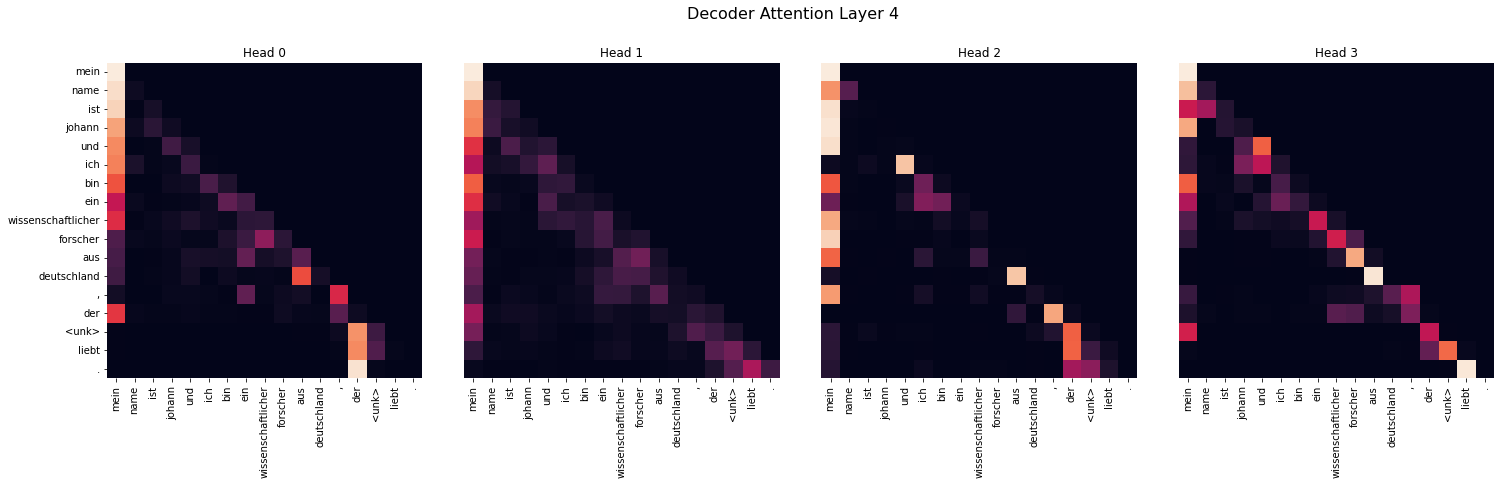

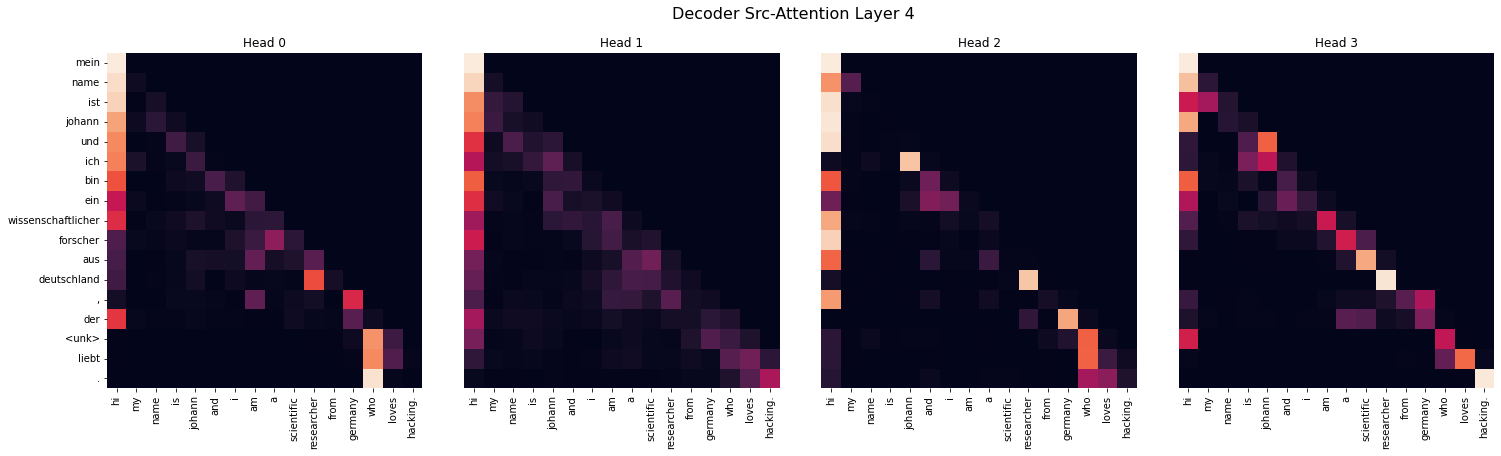

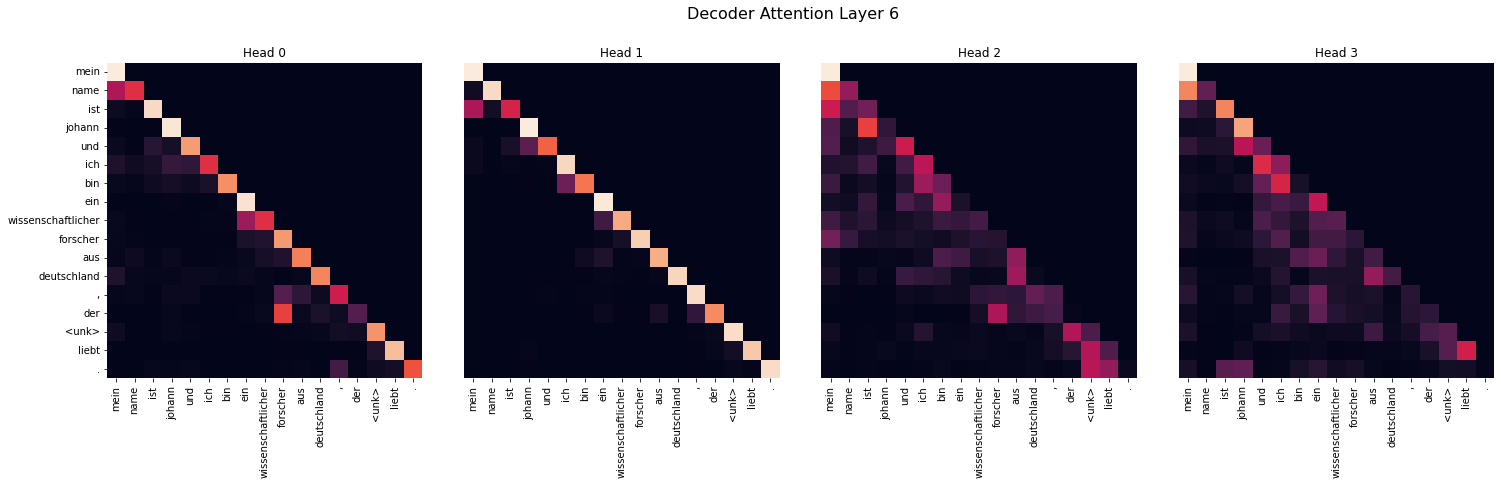

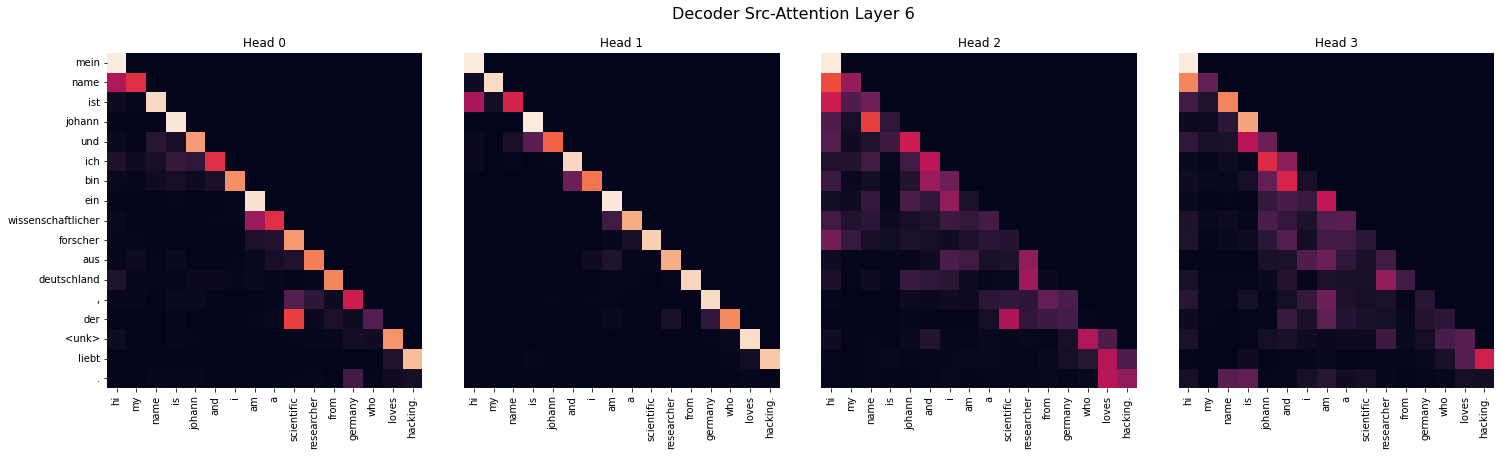

In [61]:
tgt_sent = translation.split()

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 6))
    fig.suptitle(f'Decoder Attention Layer {layer+1}', fontsize=16)
    fig.tight_layout()
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
        axs[h].set_title(f"Head {h}")
    plt.show()
    fig.savefig(f"decoder_attn_{layer+1}.jpg")
    
    fig, axs = plt.subplots(1,4, figsize=(20, 6))
    fig.suptitle(f'Decoder Src-Attention Layer {layer+1}', fontsize=16)
    fig.tight_layout()
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
        axs[h].set_title(f"Head {h}")
    plt.show()
    fig.savefig(f"decoder_src_attn_{layer+1}.jpg")